## Diffusion model concept test
### Train a diffusion model on larger scale galaxy images
#### Sample from p(x) to return a value for random numbered input images

In [1]:
#-------------------------------#
#  Diffusion modelling Galaxies #
#       Matt Sampson 2022       #
#-------------------------------#

# based on Denoising Diffusion Probabilistic Models 
# Ho et. al --- https://arxiv.org/abs/2006.11239

# ---------------- #
# import libraries #
# ---------------- #
import matplotlib.pyplot as plt
import random
import imageio
import numpy as np
from argparse import ArgumentParser
from scipy.stats import norm
import scipy.stats as stats
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.spatial import distance
from scipy.special import rel_entr


from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda

import torchvision.transforms as T
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets.mnist import MNIST, FashionMNIST

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


Lets start 

Function to show a visualisation of images on a grid

In [2]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                plt.axis('off')
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

Function to visualise whats being loaded in under the hood

In [3]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

Lets load in the data, since we are using noise reversing diffusion, and noise is distriubted normally, normalise the images to [-1,1].

In [4]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
#-------------------------------------------------------------#
#                     galaxy zoo loader                       #
#-------------------------------------------------------------#
im_size = 224 
transform  = T.Compose([
        ToTensor(),
        T.Resize(size=(im_size, im_size)),
        Lambda(lambda x: (x - 0.5) * 2),
        T.Grayscale(num_output_channels=1)])
file_name = 'galaxies/'
dataset = datasets.ImageFolder(file_name,
                        transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True)
#-------------------------------------------------------------#
print(dataset)

Dataset ImageFolder
    Number of datapoints: 34988
    Root location: galaxies/
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               Lambda()
               Grayscale(num_output_channels=1)
           )


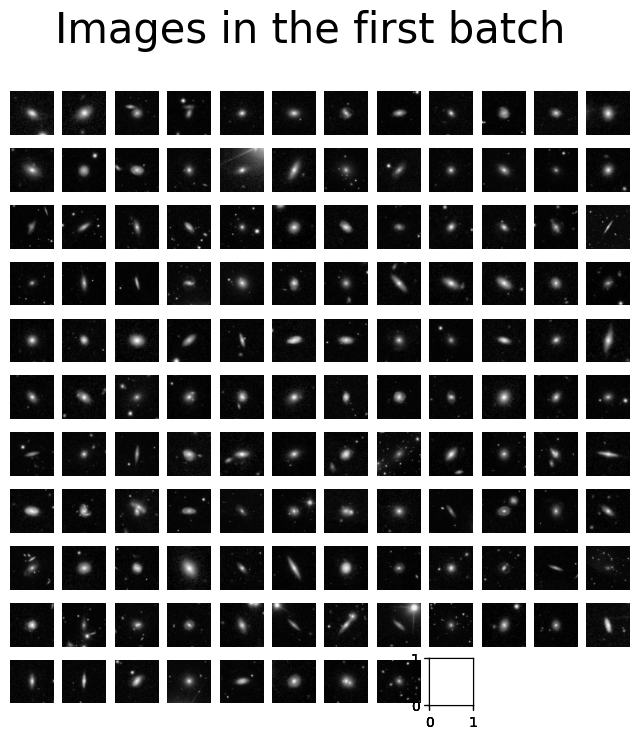

In [5]:
# Optionally, show a batch of regular images
show_first_batch(loader)

Here we use whatever architecture we have available

In [6]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	Tesla K80


Making a diffusion model class

In [7]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, im_size, im_size)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy
    
    # --------------------- #
    # Define score function #
    # --------------------- #
    '''
    Ho et al. use a parametisation of the score function here.
    We want to directly estimate the score function to then
    evaluate it for a sample image.
    
    Ho et al. use a parametisation from the Song et al. model
    meaning optimising for noise (here) would be equiv to
    optimising for the score function.
    '''

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

In [8]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [9]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=im_size, w=im_size):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

In [10]:
# -------------------- #
# sinusoidal embedding #
# -------------------- #
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [11]:
# --------------------- #
# create standard block #
# --------------------- #
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [12]:
# ------------------- #
# create n * 28 U-NET #
# ------------------- #
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()
        scale = int( im_size / 28 ) # scale to variable size

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, scale * 28, scale * 28), 1, 10),
            MyBlock((10, scale * 28, scale * 28), 10, 10),
            MyBlock((10, scale * 28, scale * 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, scale * 14, scale * 14), 10, 20),
            MyBlock((20, scale * 14, scale * 14), 20, 20),
            MyBlock((20, scale * 14, scale * 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, scale * 7, scale * 7), 20, 40),
            MyBlock((40, scale * 7, scale * 7), 40, 40),
            MyBlock((40, scale * 7, scale * 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            #nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck -- Fixed
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, int(scale * 7 / 2), int(scale * 7 / 2)), 40, 20),
            MyBlock((20, int(scale * 7 / 2), int(scale * 7 / 2)), 20, 20),
            MyBlock((20, int(scale * 7 / 2), int(scale * 7 / 2)), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            #nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, scale * 7, scale * 7), 80, 40),
            MyBlock((40, scale * 7, scale * 7), 40, 20),
            MyBlock((20, scale * 7, scale * 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, scale * 14, scale * 14), 40, 20),
            MyBlock((20, scale * 14, scale * 14), 20, 10),
            MyBlock((10, scale * 14, scale * 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, scale * 28, scale * 28), 20, 10),
            MyBlock((10, scale * 28, scale * 28), 10, 10),
            MyBlock((10, scale * 28, scale * 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [13]:
# -------------- #
# Defining model #
# -------------- #
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [14]:
# Optionally, show the diffusion (forward) process
#show_forward(ddpm, loader, device)

Calculate prob of image by evaluating log likihood of each pixel in image, then summing them up
For a given image, compute the likelyhood that it comes from a gaussian distribution

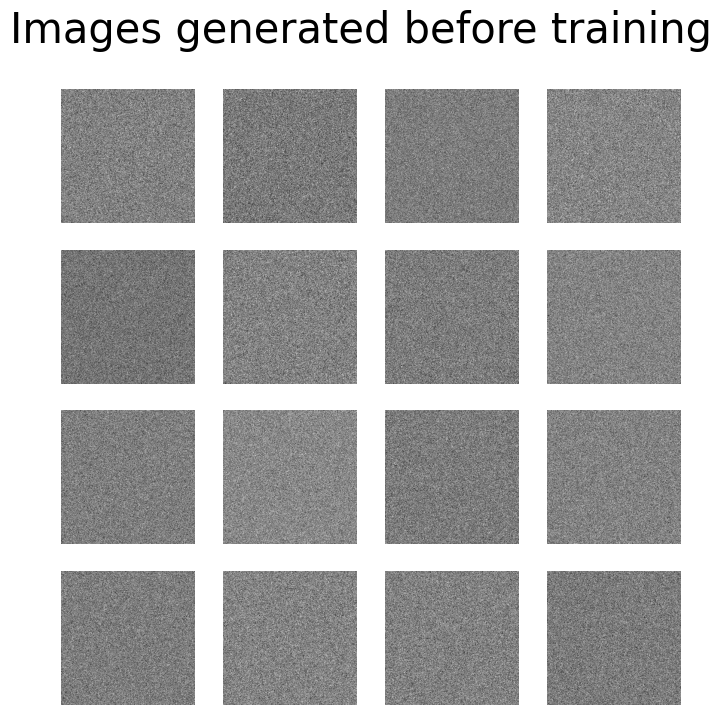

In [15]:
# Optionally, show the denoising (backward) process
generated = generate_new_images(ddpm, gif_name="before_training.gif")
show_images(generated, "Images generated before training")

In [16]:
# ------------- #
# training loop #
# ------------- #
def training_loop(ddpm, loader, n_epochs, optim, device, display=True, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Storing model"

        print(log_string)

In [17]:
# ------------------- # 
# ML model parameters #
# ------------------- #
no_train = True         # re-train yes or no
n_epochs = 15           # number of training epochs
lr = 0.001              # learning rate

In [18]:
#-------------------------------------#
# Adroit GPU trained models 15 epochs #
#-------------------------------------#
#store_path = "224_MNIST.pt"
#store_path = "224_fashion.pt"
store_path = "224_galaxies.pt"

# training step if training
if not no_train:
    training_loop(ddpm, loader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

In [19]:
# ------------------------- #
# Loading the trained model #
# ------------------------- #
best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()         # setting model to evaluation mode -- use this for classification testing/image generation

MyDDPM(
  (network): MyUNet(
    (time_embed): Embedding(1000, 100)
    (te1): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1, out_features=1, bias=True)
    )
    (b1): Sequential(
      (0): MyBlock(
        (ln): LayerNorm((1, 224, 224), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): SiLU()
      )
      (1): MyBlock(
        (ln): LayerNorm((10, 224, 224), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): SiLU()
      )
      (2): MyBlock(
        (ln): LayerNorm((10, 224, 224), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(10, 10, kernel_size=(3, 3

In [20]:
# ---------------------- #
# generate sample images #
# ---------------------- #
'''
generated = generate_new_images(
        best_model,
        n_samples=25,
        device=device,
        gif_name="hi_res_galaxies_sampson.gif"
    )
show_images(generated, "Hi res galaxy zoo")
'''

'\ngenerated = generate_new_images(\n        best_model,\n        n_samples=25,\n        device=device,\n        gif_name="hi_res_galaxies_sampson.gif"\n    )\nshow_images(generated, "Hi res galaxy zoo")\n'

In [21]:
from IPython.display import Image, display
# display(Image('hi_res_galaxies_sampson.gif', width=600)) # optionally show a gif of evolution

In [22]:
# ------------------------------------------------------------ #
#                         MNIST loader                         #
# ------------------------------------------------------------ #
transform  = T.Compose([
        ToTensor(),
        T.Resize(size=(im_size, im_size)),
        Lambda(lambda x: (x - 0.5) * 2)])
ds_fn = MNIST 
dataset = ds_fn("./datasets", download=True, 
                train=True, transform=transform)
loader_MNIST = DataLoader(dataset, batch_size=1, shuffle=True)
# ------------------------------------------------------------ #

# ------------------------------------------------------------ #
#                      galaxy zoo loader                       #
# ------------------------------------------------------------ #
transform  = T.Compose([
        ToTensor(),
        T.Resize(size=(im_size, im_size)),
        Lambda(lambda x: (x - 0.5) * 2),
        T.Grayscale(num_output_channels=1)])
file_name = 'galaxies/'
dataset = datasets.ImageFolder(file_name,
                        transform=transform)
loader_zoo = DataLoader(dataset, batch_size=1, shuffle=True)
# ----------------------------------------------------------- #

# ----------------------------------------------------------- #
#                    fashion data loader                      #
# ----------------------------------------------------------- #
transform  = T.Compose([
        ToTensor(),
        T.Resize(size=(im_size, im_size)),
        Lambda(lambda x: (x - 0.5) * 2)])
ds_fn = FashionMNIST
dataset = ds_fn("./datasets", download=True, 
                train=True, transform=transform)
loader_fashion = DataLoader(dataset, batch_size=1, shuffle=True)
# ----------------------------------------------------------- #

In [23]:
# ------------------------------ #
# running the classifying metric #
# ------------------------------ #
percent = np.logspace(-1/3 , 0 , 40)
error_percentage_MNIST = np.ones(len(percent))
error = 0
error_single = 0
count = 0
trials = 100
error_1 = []
error_2 = []
error_3 = []
n_steps = n_steps - 1

                
for i in tqdm(range( len(percent) ), desc=f"Testing progress MNIST", colour="#00ff00"):
        for batch in loader_MNIST:
                if (count < trials):
                        # Load in the image to get predicted noice tensor eta
                        x0 = batch[0].to(device)
                        n = len(x0)
                        percent_diffuse = percent[i]
                        eta_defined = torch.randn_like(x0).to(device)
                        #t = torch.tensor([int( percent_diffuse * n_steps ) -1]).to(device).long()
                        t = torch.randint(int( percent_diffuse * n_steps ), 
                                          int( percent_diffuse * n_steps ) + 1, (n,)).to(device)
                        # Computing the noisy image based on x0 and the time-step (forward process)
                        noisy_imgs = best_model.forward(x0, t, eta_defined) # use forward diffusion process for noise
                        #noisy_imgs = best_model(x0, t, eta_defined)
                        eta_trained_guess = best_model.backward(noisy_imgs, t.reshape(n, -1))               
                        mse = nn.MSELoss()
                        loss = mse(eta_trained_guess, eta_defined) 
                        loss.backward() # added
                        loss = loss.item() / len(x0)
                        error += loss
                        error_single += loss
                
                count += 1
                
                # store error for individual trials
                error_1 = np.append(error_1, error_single)
                error_single = 0
                
                # end after collected all trial info
                if (count > trials):
                        break
        
        error_percentage_MNIST[i] = error / trials
        error = 0
        count = 0

Testing progress MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

In [24]:
error_percentage_zoo = np.ones(len(percent))
error = 0
count = 0
for i in tqdm(range( len(percent) ), desc=f"Testing progress Zoo", colour="#00ff00"):
        for batch in loader_zoo:
                if (count < trials):
                        # Load in the image to get predicted noice tensor eta
                        x0 = batch[0].to(device)
                        n = len(x0)
                        percent_diffuse = percent[i]
                        eta_defined = torch.randn_like(x0).to(device)
                        #t = torch.tensor([int( percent_diffuse * n_steps ) -1]).to(device).long()
                        t = torch.randint(int( percent_diffuse * n_steps ), 
                                          int( percent_diffuse * n_steps ) + 1, (n,)).to(device)
                        # Computing the noisy image based on x0 and the time-step (forward process)
                        noisy_imgs = best_model.forward(x0, t, eta_defined) # use forward diffusion process for noise
                        #noisy_imgs = best_model(x0, t, eta_defined)
                        eta_trained_guess = best_model.backward(noisy_imgs, t.reshape(n, -1))                    
                        mse = nn.MSELoss()
                        loss = mse(eta_trained_guess, eta_defined) 
                        loss.backward() # added
                        loss = loss.item() / len(x0)
                        error += loss
                        error_single += loss
                
                count += 1
                
                # store error for individual trials
                error_2 = np.append(error_2, error_single)
                error_single = 0

                
                # end after collected all trial info
                if (count > trials):
                        break
                
        error_percentage_zoo[i] = error / trials
        error = 0
        count = 0


Testing progress Zoo:   0%|          | 0/40 [00:00<?, ?it/s]

In [25]:
error_percentage_fashion = np.ones(len(percent))
error = 0
count = 0

for i in tqdm(range( len(percent) ), desc=f"Testing progress Fashion", colour="#00ff00"):
        for batch in loader_fashion:
                if (count < trials):
                        # Load in the image to get predicted noice tensor eta
                        x0 = batch[0].to(device)
                        n = len(x0)
                        percent_diffuse = percent[i]
                        eta_defined = torch.randn_like(x0).to(device)
                        #t = torch.tensor([int( percent_diffuse * n_steps ) -1]).to(device).long()
                        t = torch.randint(int( percent_diffuse * n_steps ), 
                                          int( percent_diffuse * n_steps ) + 1, (n,)).to(device)
                        # Computing the noisy image based on x0 and the time-step (forward process)
                        noisy_imgs = best_model.forward(x0, t, eta_defined) # use forward diffusion process for noise
                        #noisy_imgs = best_model(x0, t, eta_defined)
                        eta_trained_guess = best_model.backward(noisy_imgs, t.reshape(n, -1))    
                        mse = nn.MSELoss()
                        loss = mse(eta_trained_guess, eta_defined) 
                        loss.backward() # added
                        loss = loss.item() / len(x0)
                        error += loss
                        error_single += loss
                
                count += 1
                
                # store error for individual trials
                error_3 = np.append(error_3, error_single)
                error_single = 0
                
                # end after collected all trial info
                if (count > trials):
                        break
                
        error_percentage_fashion[i] = error / trials
        error = 0
        count = 0

Testing progress Fashion:   0%|          | 0/40 [00:00<?, ?it/s]

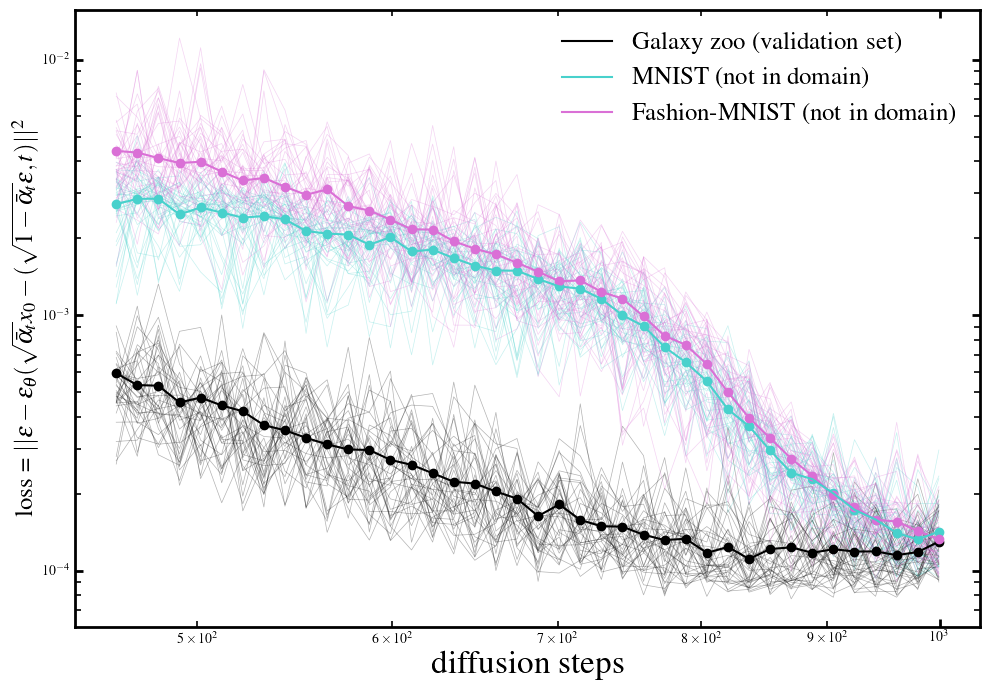

In [26]:
import matplotlib as mpl
from matplotlib import rc
# plot aesthetics
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.top'] = 'true'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.right'] = 'true'
mpl.rcParams['axes.linewidth'] =  2     # edge line width
mpl.rcParams['xtick.major.size'] =     6     # major tick size in points
mpl.rcParams['xtick.minor.size'] =     4.5       # minor tick size in points
mpl.rcParams['xtick.major.width'] =    2     # major tick width in points
mpl.rcParams['xtick.minor.width'] =    1.2 
mpl.rcParams['ytick.major.size'] =     6     # major tick size in points
mpl.rcParams['ytick.minor.size'] =     4.5       # minor tick size in points
mpl.rcParams['ytick.major.width'] =    2     # major tick width in points
mpl.rcParams['ytick.minor.width'] =    1.2 
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

# colours
col_MNIST   = 'mediumturquoise'
col_ZOO     = 'black'
col_fashion = 'orchid'
x = percent * n_steps

fig= plt.figure(figsize=(10, 7), dpi = 100)


#------------------------------#
#- plot the individual trials -#
for j in range(len(percent)):
    # start value
    start = j
    # skipping every 4th element
    n = trials
    # declaring new list
    new_arr = []  
    # looping over array
    for i in error_1:
        # checking if element is nth pos
        if(start % n == 0):
            if (i != 0.0):
                new_arr.append(i)
        # incrementing counter
        start += 1 
    plt.plot(x, new_arr , color = col_MNIST, lw = 0.5, alpha = 0.3)
    
    
for j in range(len(percent)):
    # start value
    start = j
    # skipping every 4th element
    n = trials
    # declaring new list
    new_arr = []  
    # looping over array
    for i in error_2:
        # checking if element is nth pos
        if(start % n == 0):
            if (i != 0.0):
                new_arr.append(i)
        # incrementing counter
        start += 1 
    plt.plot(x, new_arr , color = col_ZOO, lw = 0.5, alpha = 0.3)
    
    
for j in range(len(percent)):
    # start value
    start = j
    # skipping every 4th element
    n = trials
    # declaring new list
    new_arr = []  
    # looping over array
    for i in error_3:
        # checking if element is nth pos
        if(start % n == 0):
            if (i != 0.0):
                new_arr.append(i)
        # incrementing counter
        start += 1 
    plt.plot(x, new_arr , color = col_fashion, lw = 0.5, alpha = 0.3)



plt.plot(x, error_percentage_zoo, label = r'Galaxy zoo (validation set)', color = col_ZOO, zorder = 2)
plt.scatter(x, error_percentage_zoo, zorder = 2, color = col_ZOO)
plt.plot(x, error_percentage_MNIST, label = 'MNIST (not in domain)', color = col_MNIST, zorder = 4)
plt.scatter(x, error_percentage_MNIST, zorder = 2, color = col_MNIST)
plt.plot(x, error_percentage_fashion, label = r'Fashion-MNIST (not in domain)', color = col_fashion, zorder = 2)
plt.scatter(x, error_percentage_fashion, zorder = 2, color = col_fashion)
plt.xlabel('diffusion steps',fontsize = 24)
#plt.ylabel(r"$\langle \ \rm{JS}  \ $ $(p(x)  || \ \mathcal{N}(0,1)  \ \rangle $",fontsize = 24)
plt.ylabel(r'logliklihood $\{ \mathbf{x} \} \in \mathcal{N}(0,1)$', fontsize = 24)
plt.ylabel(r'loss = $|| \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_t}x_0 - (\sqrt{1 - \bar{\alpha}_t}\epsilon,t)||^2$', fontsize = 18)


#- log scaling -#
locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax = plt.gca()
plt.tick_params(axis='x', which='minor')
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
plt.xscale('log')
plt.yscale('log')


plt.legend(frameon = False, fontsize = 18)
plt.tight_layout()
plt.savefig('compare_sets_224.png',facecolor='white', transparent=False ,dpi = 250)